<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 4
*Fit splines into single features in your project data. Explore options to obtain the best fit.*

Los datos utilizados en este cuaderno están disponibles aquí: [datasets](https://drive.google.com/drive/folders/159GnBJQDxTY9oYqPBZzdNghyb4Gd9pDS?usp=sharing)

In [2171]:
import numpy as np
import pandas as pd
import itertools
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from scipy import interpolate
import scipy.stats
import statsmodels.api as sm
import statsmodels.tools.eval_measures as bias
import seaborn as sns
warnings.filterwarnings("ignore")

from matplotlib.pyplot import figure
from numpy.random import normal
import numpy as np

In [2172]:
#función que calcula la predicción Y[] de un X[] usando los parametros o coeficientes de regresión beta[]
def pronostica(params,X): #params:parámetros de regresión; X:datos de regresores 
    y = []
    i = 0
    for rows in X:
        y.append(np.matmul(params,X[i]))
        i = i + 1
    return(y)

In [2173]:
def dibuja_hist(df,colour,name,Xlabel,Ylabel,title):
    plt.figure()
    df.hist(column=0, bins=25, grid=False, figsize=(6,3), color=colour, zorder=2, rwidth=0.9)
    plt.xticks(rotation=90)
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    #https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors/42020486
    mytitle = plt.title(title) # get the title property handler   #plt.getp(title_obj)  
    plt.setp(mytitle, color='#ff8000')                            # set the color of title
    myax = plt.axes()   # get the axis property handler           # plt.getp(myax) print its propieties
    myax.xaxis.label.set_color('#ff8000')
    myax.yaxis.label.set_color('#ff8000')
    myax.tick_params(colors='#ff8000', which='both')              # myax.spines['bottom'].set_color('yellow')
    plt.savefig(name, transparent=True)
    plt.show()                                                    # o plt.save_en_algún_formato()

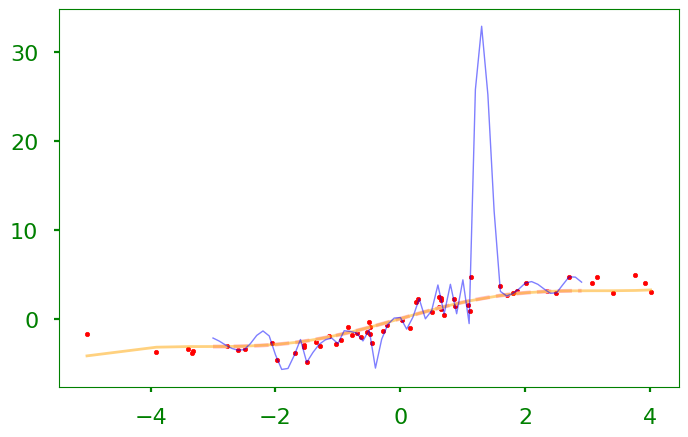

In [2174]:
figure(figsize = (8, 5), dpi = 100)
xt = np.arange(-3, 3, 0.1) # true x coordinates
n  = len(xt)
magnitude = 1 ## noise
x  = np.sort(xt + normal(size = n, scale = magnitude)) # add noise and SORT
yt = np.sin(xt) + xt                                   # true y coordinates
y  = yt + normal(size = n, scale = magnitude)          # add noise

st = interpolate.CubicSpline(xt, yt) # fit a cubic spline to the pure data
s  = interpolate.CubicSpline(x,  y)  # fit a cubic spline to the noisy data

plt.rcParams.update({'text.color': 'green',
                     'xtick.color': 'green',
                     'ytick.color': 'green',
                     'axes.labelcolor': 'green',
                     'axes.edgecolor': 'green',
                     'axes.facecolor':  'none' })
plt.scatter( x,  y,     c = 'red'   , s = 10) # data
plt.plot   ( xt, yt,    c = 'pink'  , linestyle = 'dashed'      ) # pure model
plt.plot   ( x,  st(x), c = 'orange', linewidth = 2, alpha = 0.5) # clean spline
plt.plot   ( xt, s(xt), c = 'blue'  , linewidth = 1, alpha = 0.5) # noisy spline
plt.savefig('spline.png', transparent = True)

## Tranformación de base en predicción de demanda eléctrica

A continuación aplicaremos técnicas de expansión de base aplicados a predicción de demanda eléctrica por regresión, tal como se hizo en el la [tarea 3](https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea3.ipynb#scrollTo=Ext-myaET2n5). Recordando que la variable independiente $X$ serán los datos de demanda del día anterior, y los datos independiente $Y$ serán los datos de días con una mayor correlación. Compararemos el desempeño de usar transformación variables y algunas técnicas de reducción de dimensiones como **stepwise**.

Los datos usados en esta sección están disponibles en [demanda.csv](https://drive.google.com/file/d/1KpY2p4bfVEwGRh5tJjMx9QpH6SEwrUwH/view?usp=sharing)

In [2175]:
df = pd.read_csv('demanda.csv')

In [2176]:
## Procesamos datos de entrenamiento 
df1 = df.loc[df.iloc[:,19].isin(['T'])] ## 'T' = training set
df2 = df1['Y']  
df1 = df1[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']] ## Regresores

Ahora, cargamos los datos de prueba en los arreglos `X_train` y `y_train`:

In [2177]:
## Procesamos datos de prueba 
dft = df.loc[df.iloc[:,19].isin(['F'])] ## 'F' = test set
dft2 = dft['Y']
dft1 = dft[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']] ## Regresores

In [2178]:
df1.std(numeric_only = True) 
df1.mean(numeric_only = True)
df1 = df1 - df1.mean(numeric_only = True)
df1 = df1 / df1.std(numeric_only = True) 
X_train = df1.to_numpy()   ## Predictors
X_train = sm.add_constant(X_train)
y_train = df2.to_numpy()   ## Outcome

In [2179]:
x    = np.arange(len(X_train[:,9]))
y    = X_train[:,9]
tck  = interpolate.splrep(x, y, s=3)
ynew = interpolate.splev(x, tck, der=0)
ycs  = interpolate.CubicSpline(x, y,extrapolate=True)
yder = interpolate.splev(x, tck, der=2)

No handles with labels found to put in legend.


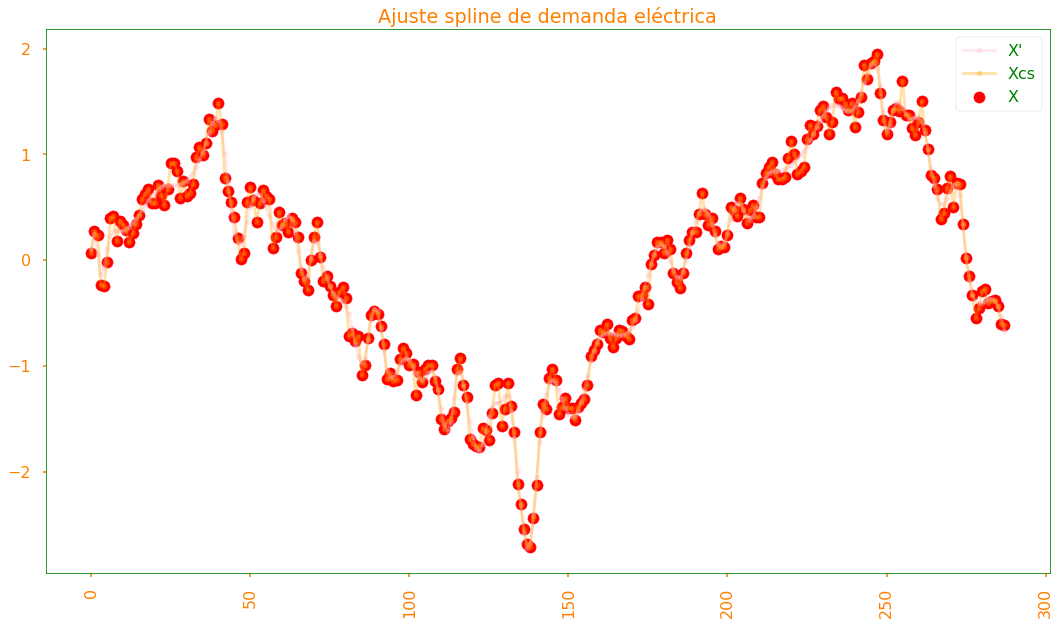

In [2180]:
fig  = plt.figure(figsize=(18,10))
#plt.style.use("seaborn-poster")
axes = fig.add_subplot(1, 1, 1)
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'
mytitle = plt.title('Ajuste spline de demanda eléctrica') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color='#ff8000')                                        #set the color of title to red
axes.xaxis.label.set_color('#ff8000')
axes.yaxis.label.set_color('#ff8000')
axes.tick_params(   colors='#ff8000', which='both')

plt.scatter( x , y , color = 'red'   , label = 'X'    )

axes.plot( x , ynew   , '.-', color = 'pink'   , label = 'X\''   ,alpha=1/3)
axes.plot( x , ycs(x) , '.-', color = 'orange' , label = 'Xcs'   ,alpha=1/3)

#plt.axis([0, 20, -1, 1])
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('pronodemanda.png', transparent=True)
#plt.legend(['Linear', 'Cubic Spline'])  
plt.show()

## Interpolación spline en series de tiempo de aportaciones en embalses
 Ahora haremos un ejemplo con datos de una serie de tiempo de aportaciones (lluvias) en embalses (presas) de Peñitas (PEA) una de las principales centrales hidroeléctricas en el país, ubicada en Tabasco, México. 

 Queremos probar el uso de splines en interpolación de datos perdidos. La serie original está completa y borraremos algunos datos aleatoriamente. Despúes los completaremos usando interpolación líneal y c´´ubica y compararemos su desempeño usando el error absoluto medio. 

In [2181]:
## Leemos y guardamos los datos originales
df  = pd.read_csv('Aportaciones_Embalses.csv')
df  = df.dropna() ## remove all lines with missing observations
dfx = df['x']  
reservoir=['MMT'] ## Solo tomaremos Peñitas pero podría ser cualquiera de los demás embalses
dfy = df[reservoir] 
n = len(dfx)
print(len(dfx))

790


In [2182]:
## De la serie original borraremos algunos datos aleatoriamente.
r = round(len(df) * 0.1 )
np.random.seed(0)
random=[]
for i in range(r):
    random.append(np.random.randint(0,len(df)))
missing = []
for i in random:
    if i not in missing:
        missing.append(i)

df_missing = df
df_missing = df_missing.drop( index = missing )

dfx_missing = df_missing['x']  
dfy_missing = df_missing[reservoir]

In [2183]:
x = dfx_missing 
y = dfy_missing

In [2185]:
## Spline de primer orden (k = 1)
tck  = interpolate.splrep(x, y, k = 1)
xor1 = np.arange(0, n-1, 1/50)
yor1 = interpolate.splev(xor1, tck)

## Comparamos contra los datos originales usando el MAE
y_or1    = interpolate.splev(dfx, tck) ## Esta variable se usará para comparar contra el original
err_or1  = mean_absolute_error(dfy,y_or1)
print(err_or1)

7.357213080168777


In [2186]:
## Spline de segundo orden (k = 2)
tck  = interpolate.splrep(x, y, k = 2)
xor2 = np.arange(0, n-1, 1/50)
yor2 = interpolate.splev(xor2, tck)

## Comparamos contra los datos originales usando el MAE
y_or2    = interpolate.splev(dfx, tck) ## Esta variable se usará para comparar contra el original
err_or2  = mean_absolute_error(dfy,y_or2)
print(err_or2)

7.965839116579703


In [2187]:
## Spline de tercer orden (k = 3) equivalente a CubicSpline
tck  = interpolate.splrep(x, y, k = 3)
xor3 = np.arange(0, n-1, 1/50)
yor3 = interpolate.splev(xor3, tck)

## Comparamos contra los datos originales usando el MAE
y_or3    = interpolate.splev(dfx, tck) ## Esta variable se usará para comparar contra el original
err_or3  = mean_absolute_error(dfy,y_or3)
print(err_or3)

8.165197051423274


In [2188]:
## Spline de cuarto orden (k = 4)
tck  = interpolate.splrep(x, y, k = 4)
xor4 = np.arange(0, n-1, 1/50)
yor4 = interpolate.splev(xor4, tck)

## Comparamos contra los datos originales usando el MAE
y_or4    = interpolate.splev(dfx, tck) ## Esta variable se usará para comparar contra el original
err_or4  = mean_absolute_error(dfy,y_or4)
print(err_or4)

9.463666852790798


In [2189]:
## Spline de quinto orden (k = 5)
tck  = interpolate.splrep(x, y, k = 5)
xor5 = np.arange(0, n-1, 1/50)
yor5 = interpolate.splev(xor5, tck)

## Comparamos contra los datos originales usando el MAE
y_or5    = interpolate.splev(dfx, tck) ## Esta variable se usará para comparar contra el original
err_or5  = mean_absolute_error(dfy,y_or5)
print(err_or5)

9.918979203332759


In [2190]:
## InterpolatedUnivariateSpline
s = interpolate.InterpolatedUnivariateSpline(x, y)
xus = np.arange(0, n-1, 1/50)
yus = s(xus)

## Comparamos contra los datos originales usando el MAE
y_us    = s(dfx) ## Esta variable se usará para comparar contra el original
err_us  = mean_absolute_error(dfy,y_us)
print(err_us)

8.165197051423274


In [2191]:
## B-spline interpolation
tck = interpolate.splrep(x, y, s=0, k=3) 
xbs = np.arange(0, n-1, 1/50)
ybs = interpolate.BSpline(*tck)(xbs)

## Comparamos contra los datos originales usando el MAE
y_bs    = interpolate.BSpline(*tck)(dfx) ## Esta variable se usará para comparar contra el original
err_bs  = mean_absolute_error(dfy,y_bs)
print(err_bs)

8.165197051423274


In [2184]:
## CubicSpline
xcs = np.arange(0, n-1, 1/50)
cs  = interpolate.CubicSpline(x, y)
ycs = cs(xcs)

## Comparamos contra los datos originales usando el MAE
y_cs    = cs(dfx) ## Esta variable se usará para comparar contra el original
err_cs  = mean_absolute_error(dfy,y_cs)
print(err_cs)

8.165197051423249


No handles with labels found to put in legend.


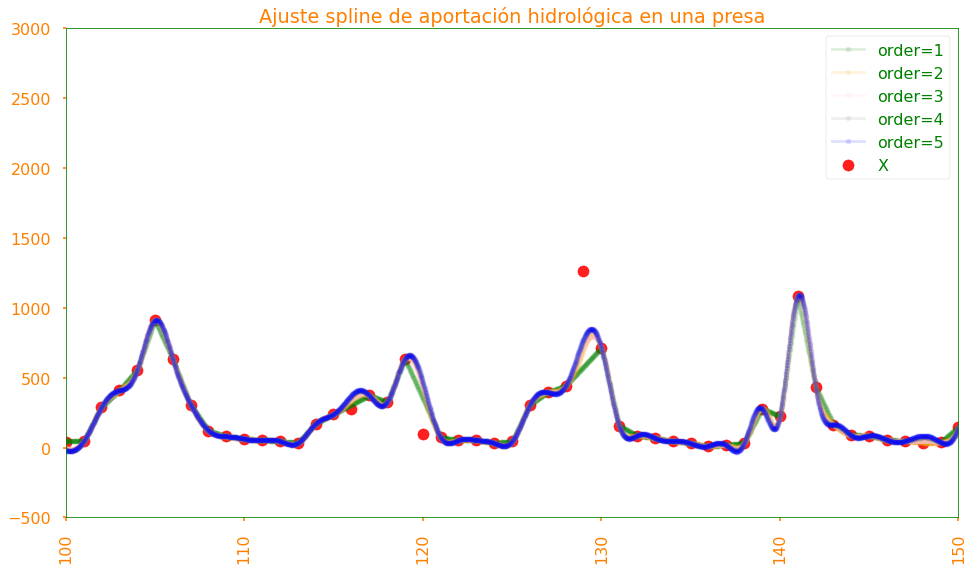

In [2192]:
import matplotlib.animation as animation
fig  = plt.figure(figsize=(16,9))
axes = fig.add_subplot(1, 1, 1)
#plt.style.use("seaborn-poster")
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'
mytitle = plt.title('Ajuste spline de aportación hidrológica en una presa') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color='#ff8000')                                        #set the color of title to red
axes.xaxis.label.set_color('#ff8000')
axes.yaxis.label.set_color('#ff8000')
axes.tick_params(   colors='#ff8000', which='both')

plt.scatter( dfx, dfy,          color = 'red'    , label = 'X'        ,alpha=7/8)
axes.plot  ( xor1, yor1 , '.-', color = 'green'  , label = 'order=1'  ,alpha=1/8)
axes.plot  ( xor2, yor2 , '.-', color = 'orange' , label = 'order=2'  ,alpha=1/8)
axes.plot  ( xor3, yor3 , '.-', color = 'pink'   , label = 'order=3'  ,alpha=1/8)
axes.plot  ( xor4, yor4 , '.-', color = 'gray'   , label = 'order=4'  ,alpha=1/8)
axes.plot  ( xor5, yor5 , '.-', color = 'blue'   , label = 'order=5'  ,alpha=1/8)
#axes.plot  ( xbs,  ybs  , '.-', color = 'cyan'   , label = 'B-spline ',alpha=1/8)

plt.axis([100, 150, -500, 3000])
#plt.axis([150, 300, -500, 3000])
#plt.axis([350, 500, -500, 3000])
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('pronodemanda.png', transparent=True)
#plt.legend(['Linear', 'Cubic Spline'])  
plt.show()

[Spline Interpolation Example in Python](https://www.datatechnotes.com/2021/11/spline-interpolation-example-in-python.html)

[Creating and Plotting Cubic Splines in Python](https://www.analytics-link.com/post/2018/08/17/creating-and-plotting-cubic-splines-in-python)


[B-spline Curve Fitting Example in Python](https://www.datatechnotes.com/2021/11/b-spline-fitting-example-in-python.html)

[documentación scipy.interpolate.CubicSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html)